# Fraud Detection Model 

## Requirements 

- Use data science & ML to detect fraud in financial transactions
- Train models using historical transaction data
- Perform real-time detection via streaming with Apache Kafka
- Display flagged transactions in a live dashboard, showing reasons for flagging & fraud probability

## In this project 
We will be using data from the Credit Card Fraud dataset: https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022/data to determine & train the best model for credit card detection 

To do this we will be measuring multiple models against several measurement methods i.e. Precision, Accuracy to determine how reliable the model is

### Data Description

#### 1.0 Loading the Data

In [1]:
from imblearn.over_sampling import SMOTE
import pandas as pd 
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('../data/Variant I.csv')
df.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.011029,0.560867,4.946516e-01,16.960120,83.585392,31.974200,1.051720e+00,8.715090,1574.468789,5661.914760,...,0.898214,10.799300,0.218157,507.156910,0.025010,7.464706,0.579841,1.016889,0.0,3.288668
std,0.104438,0.290389,2.888474e-01,43.870653,86.458280,10.897167,5.462110e+00,20.210541,1003.700453,3010.869604,...,0.302367,12.121409,0.412995,481.460578,0.156155,7.948670,0.493584,0.175465,0.0,2.209990
min,0.000000,0.100000,5.024707e-08,-1.000000,-1.000000,10.000000,1.373749e-08,-15.739893,1.000000,-174.109691,...,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,0.300000,2.268462e-01,-1.000000,18.000000,20.000000,7.150757e-03,-1.180401,893.000000,3431.170414,...,1.000000,-1.000000,0.000000,200.000000,0.000000,3.092919,0.000000,1.000000,0.0,1.000000
50%,0.000000,0.600000,4.922199e-01,-1.000000,50.000000,30.000000,1.510390e-02,-0.828224,1270.000000,5299.991908,...,1.000000,5.000000,0.000000,200.000000,0.000000,5.081925,1.000000,1.000000,0.0,3.000000
75%,0.000000,0.800000,7.558383e-01,15.000000,124.000000,40.000000,2.618513e-02,6.215877,1952.000000,7692.312342,...,1.000000,25.000000,0.000000,500.000000,0.000000,8.758878,1.000000,1.000000,0.0,5.000000
max,1.000000,0.900000,1.000000e+00,399.000000,429.000000,90.000000,7.663502e+01,113.120051,6678.000000,16817.838935,...,1.000000,32.000000,1.000000,2100.000000,1.000000,85.567848,1.000000,2.000000,0.0,7.000000


In [2]:
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.9,0.990415,11,4,40,0.014640,-0.897718,AC,1853,...,0,200.0,0,INTERNET,6.150317,windows,0,1,0,0
1,0,0.4,0.781728,-1,151,30,0.013269,11.501507,AA,5447,...,0,1500.0,0,INTERNET,4.521952,windows,1,1,0,0
2,0,0.7,0.274290,-1,92,20,0.010669,23.943928,AA,2312,...,0,200.0,0,INTERNET,8.361707,other,1,1,0,0
3,0,0.9,0.722684,-1,55,20,0.021849,48.202774,AA,2413,...,0,1500.0,0,INTERNET,7.339743,other,0,1,0,0
4,0,0.9,0.121661,-1,51,20,0.021491,-1.602116,AB,1227,...,0,1500.0,0,INTERNET,4.338063,other,0,1,0,0


In [3]:
df.tail()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
999995,0,0.9,0.173671,-1,110,30,0.004057,-1.451974,AB,979,...,0,200.0,0,INTERNET,5.740367,other,1,1,0,7
999996,0,0.9,0.566285,-1,29,50,0.014215,-0.672890,AB,1190,...,0,200.0,0,INTERNET,26.319296,linux,0,1,0,7
999997,0,0.6,0.807476,-1,164,30,0.040160,46.129201,AA,1571,...,0,1000.0,0,INTERNET,1.614444,linux,1,1,0,7
999998,0,0.8,0.151376,87,12,30,0.016871,-1.212084,AC,1435,...,0,200.0,0,INTERNET,3.682591,linux,0,1,0,7
999999,0,0.8,0.145820,63,4,30,0.026896,-0.506524,AB,629,...,0,200.0,0,INTERNET,15.761976,linux,0,1,0,7


#### 1.1 Data columns

- **fraud_bool:** Whether the transaction was fraudulent or not
- **income:** Income of applicant in percentiles [0-1]
- **name_email_similarity:** Similarity between applicant name and email 
- **prev_address_months_count:**: Months in currently registered address of the applicant. Ranges between [−1, 406] months (-1 is a missing value).
- **customer_age:**: Age of customer
- **days_since_request**: Number of days passed since application was done 
- **intended_balcon_amount:** Amount user intends to borrow/spend
- **payment_type:** Credit payment plan 
- **zip_count_4w**: Number of applications within same zip code in last 4 weeks
- **velocity_6h, velocity_24h, velocity_4**: Number of transactions (or volume) in last 6 hours, 24 hours, and 4 weeks respectively
- **has_other_cards:** Whether the applicant has any other cards {0: no, 1: yes}
- **bank_branch_count_8w:** Number of total applications in the selected bank branch in the last 8 weeks
- **date_of_birth_distinct_emails_4w:** Number of emails for applicants with the same date of birth in last 4 weeks
- **employment_status:** Employment status of the applicant
- **credit_risk_score:** Internal score of application risk 
- **email_is_free:** Domain of application email (free or paid)
- **housing_status:** Current residential status for applicant
- **phone_home_valid:** Validity of provided home phone
- **phone_mobile_valid:** Validity of provided mobile phone
- **bank_months_count:** How old is the previous account in months (-1 is a missing value)
- **proposed_credit_limit:** Applicant's proposed credit limit 
- **foreign_request:** If origin country of request is different from banks' country 
- **source:** Online source of application 
- **session_length_in_minutes:** Length of user session in banking website in minutes 
- **device_os:** Operative system of device that made request
- **keep_alive_session:** User option on session logout 
- **device_distinct_emails_8w:** Number of distinct emails in banking website from the used device in the last 8 weeks 
- **device_fraud_count:** Number of fradulent applications with used device 
- **month:** Month where the application was made

#### 1.2 Removing NaN values 

In [4]:
df.isna().mean()

fraud_bool                          0.0
income                              0.0
name_email_similarity               0.0
prev_address_months_count           0.0
current_address_months_count        0.0
customer_age                        0.0
days_since_request                  0.0
intended_balcon_amount              0.0
payment_type                        0.0
zip_count_4w                        0.0
velocity_6h                         0.0
velocity_24h                        0.0
velocity_4w                         0.0
bank_branch_count_8w                0.0
date_of_birth_distinct_emails_4w    0.0
employment_status                   0.0
credit_risk_score                   0.0
email_is_free                       0.0
housing_status                      0.0
phone_home_valid                    0.0
phone_mobile_valid                  0.0
bank_months_count                   0.0
has_other_cards                     0.0
proposed_credit_limit               0.0
foreign_request                     0.0


Whilst there are no NaN values in the dataset, certain columns have in place -1 to represent missing values, for accuracy we will be dropping these rows

In [5]:
print("Number of rows before removing -1 values:", df.shape[0])

# Remove rows with -1 in specific columns
df = df[(df['bank_months_count'] != -1) & (df['prev_address_months_count'] != -1)]
print("Number of rows after removing -1 values:", df.shape[0])


Number of rows before removing -1 values: 1000000
Number of rows after removing -1 values: 204491


In [6]:
df.info()  # Display dataset statistics

<class 'pandas.core.frame.DataFrame'>
Index: 204491 entries, 14 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        204491 non-null  int64  
 1   income                            204491 non-null  float64
 2   name_email_similarity             204491 non-null  float64
 3   prev_address_months_count         204491 non-null  int64  
 4   current_address_months_count      204491 non-null  int64  
 5   customer_age                      204491 non-null  int64  
 6   days_since_request                204491 non-null  float64
 7   intended_balcon_amount            204491 non-null  float64
 8   payment_type                      204491 non-null  object 
 9   zip_count_4w                      204491 non-null  int64  
 10  velocity_6h                       204491 non-null  float64
 11  velocity_24h                      204491 non-null  float

#### 1.3 Data Description 

In [7]:
num_attributes = df.select_dtypes(exclude='object')
cat_attributes = df.select_dtypes(include='object')

fraud = df[df['fraud_bool'] == 1]
non_fraud = df[df['fraud_bool'] == 0]

##### Numerical attributes

To analyse the dataset with more clarity, we split the attributes into numerical and categorical. We will also engineer our own statistical measures to give us a better insight 

- **coefficient-variance:** Measure that expresses the extent of the variability of dispersion of a data set relative to its mean 
- **range:** Measures the range of data from its maximum to its minimum 
- **skewness:** Measures assymetry of the probability distribution of a random variable about its mean (positive, negative, or undefined)
- **kurtosis:** Measures tailedness of a distribution - how often outliers occur

In [23]:
describe = num_attributes.describe().T
describe['range'] = describe['max'] - describe['min']
describe['variance coef'] = (describe['std'] / describe['mean']).round(2)
describe['kurtosis'] = num_attributes.kurtosis().round(2)
describe

,count,mean,std,min,25%,50%,75%,max,range,variance coef,kurtosis
fraud_bool,204491.0,0.002934,0.054088,0.000000e+00,0.000000,0.000000,0.000000,1.000000,1.000000,18.43,335.83
income,204491.0,0.576279,0.283770,1.000000e-01,0.300000,0.600000,0.800000,0.900000,0.800000,0.49,-1.19
name_email_similarity,204491.0,0.474622,0.291389,1.434550e-06,0.206928,0.458359,0.733707,0.999999,0.999998,0.61,-1.18
prev_address_months_count,204491.0,58.518908,62.010128,6.000000e+00,25.000000,33.000000,61.000000,399.000000,393.000000,1.06,6.66
current_address_months_count,204491.0,21.737407,43.831848,-1.000000e+00,5.000000,10.000000,17.000000,391.000000,392.000000,2.02,24.40
customer_age,204491.0,29.652063,9.716592,1.000000e+01,20.000000,30.000000,30.000000,90.000000,80.000000,0.33,0.99
days_since_request,204491.0,1.402256,5.954581,6.467590e-08,0.007165,0.015165,0.026714,76.577505,76.577505,4.25,77.18
intended_balcon_amount,204491.0,11.426962,22.292686,-1.519723e+01,-1.174467,-0.777661,19.434323,112.881097,128.078331,1.95,4.44
zip_count_4w,204491.0,1486.256794,991.897103,1.000000e+00,787.000000,1226.000000,1858.000000,6593.000000,6592.000000,0.67,2.14
velocity_6h,204491.0,5707.024172,3093.206211,-1.069783e+02,3243.164186,5485.257321,7957.564843,16528.873628,16635.851925,0.54,-0.43


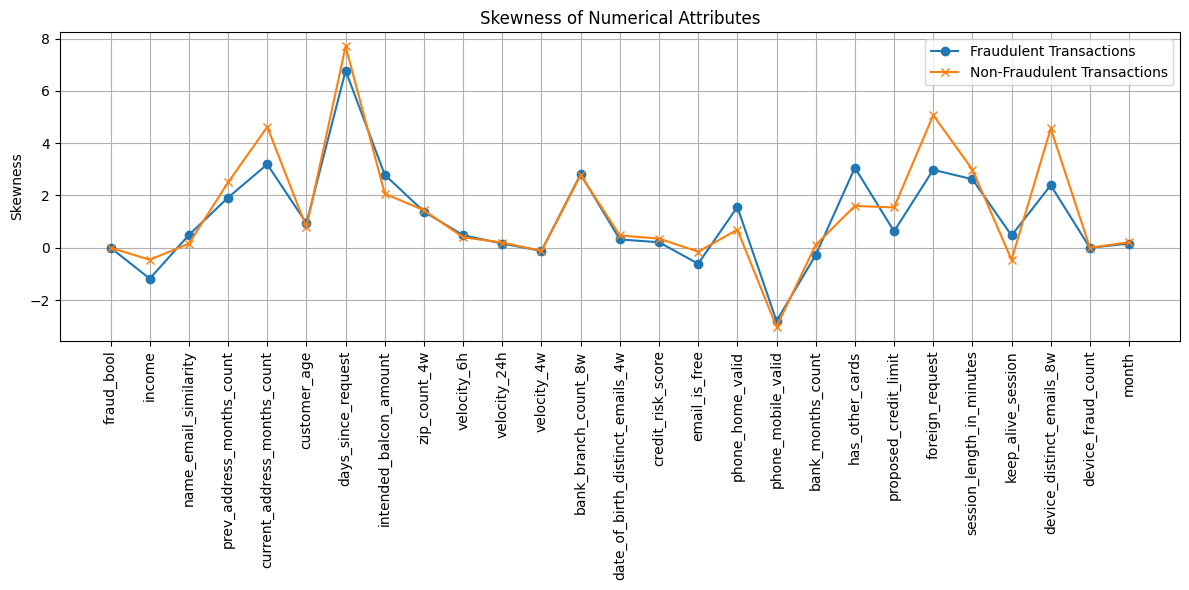

In [9]:
skew_fraud = fraud.select_dtypes(exclude='object').skew().round(2)
skew_non_fraud = non_fraud.select_dtypes(exclude='object').skew().round(2)

plt.figure(figsize=(12, 6))
plt.plot(skew_fraud, label='Fraudulent Transactions', marker='o')
plt.plot(skew_non_fraud, label='Non-Fraudulent Transactions', marker='x')
plt.xticks(rotation=90)
plt.ylabel('Skewness')
plt.title('Skewness of Numerical Attributes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


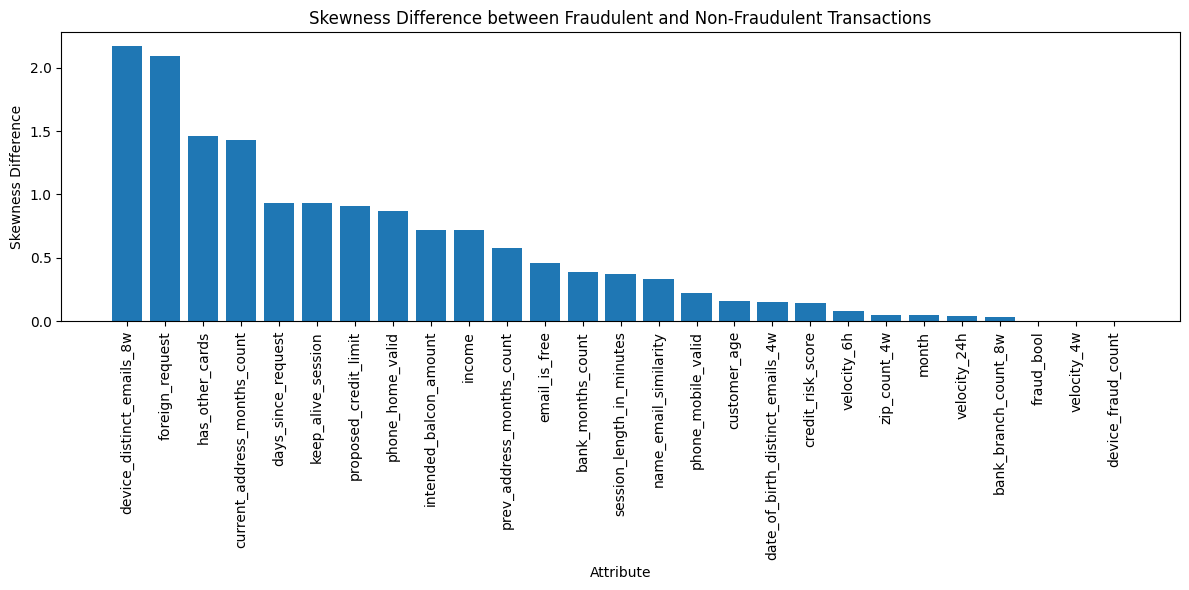

In [ ]:
skew_delta = (skew_fraud - skew_non_fraud).abs().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(skew_delta.index, skew_delta)
plt.xticks(rotation=90)
plt.xlabel('Attribute')
plt.ylabel('Skewness Difference')
plt.title('Skewness Difference between Fraudulent and Non-Fraudulent Transactions')
plt.tight_layout()
plt.show()

In [ ]:
non_fraud.describe().T

In [ ]:
fraud.describe().T

The **mean** shows us that a large number of the records are non-fraudulent -> very high class imbalance thus some form of downsampling must take place for model training 

The **skewness** and **kurtosis** are very strong indicators of variables useful to use in fraud detection. These include (but not limited to): 
- **foreign request** - skewed strongly towards non-fraud (fraud transactions are more likely to be foreign requests)
- **device_distinct_email** - skewed towards fraud (more accounts per device)
- **has_other_cards** - skewed towards fraud (less likely to have more than one card)
- **current_address_months_count** - skewed towards non-fraud (fraudulent transactions are from addresses not stayed at for very long)

We can use log transformations on heavily skewed features in our model training to make them have a higher impact on the final result. We can compare and contrast our usage of this to ensure the most optimal result


#### Categorical Attributes

In [33]:
cat_attributes.describe().T

,count,unique,top,freq
payment_type,204491,5,AB,95316
employment_status,204491,7,CA,164057
housing_status,204491,7,BC,122304
source,204491,2,INTERNET,203891
device_os,204491,5,linux,76937


In [26]:
fraud = df[df['fraud_bool'] == 1].select_dtypes(include='object')
non_fraud = df[df['fraud_bool'] == 0].select_dtypes(include='object')

In [ ]:
fraud.describe().T

,count,unique,top,freq
payment_type,600,4,AB,312
employment_status,600,7,CA,533
housing_status,600,6,BC,296
source,600,2,INTERNET,597
device_os,600,5,windows,333


In [ ]:
fraud['device_os'].value_counts(normalize=True) 

device_os
windows      0.555000
linux        0.175000
other        0.138333
macintosh    0.118333
x11          0.013333
Name: proportion, dtype: float64

In [28]:
non_fraud.describe().T

,count,unique,top,freq
payment_type,203891,5,AB,95004
employment_status,203891,7,CA,163524
housing_status,203891,7,BC,122008
source,203891,2,INTERNET,203294
device_os,203891,5,linux,76832


In [32]:
non_fraud['device_os'].value_counts(normalize=True)

device_os
linux        0.376829
other        0.306497
windows      0.239937
macintosh    0.067624
x11          0.009113
Name: proportion, dtype: float64

- Immediately the discrepancies between the device_os shows. Most fraud cases coming from windows devices whereas non_fraud cases are evenly distributed amongst devices
- Little to no variability in the categorical attributes meaning one-hot encoding will be our best option going forward

### Hypothesis

#### Data Analysis

Analysis of the data is difficult due to the large class imbalance (~0.2% of the transactions were fraud) but several different statistical measures give us a rough idea of the distribution of the data

- The average credit risk score of transactions were much higher for fraudulent transactions than non-fraudulent ones (160 vs 125)
- The velocity of payments were not skewed towards any direction and the averages were similar meaning several transactions were not carried out at once in this dataset and the use of bots can potentially be ruled out
    - Not a very good indicator of a fraudulent transaction 
- Foreign requests made up 8.5% of fraudulent transactions vs 3.5%. Not a great difference but results showed it to skew heavily towards fraudulent transactions and a high kurtosis value indicates that it could be very useful in determining if a transaction is fraudulent or not, the class imbalance may explain the small delta 
- 8% of fraud transactions came from accounts with other cards vs 18%. Skewed heavily towards fraud transactions
- Shorter address history in fraud cases, fraudsters may use new or temporary information 
- higher device distinct emails show that devices used for fraud are often reused or linked to multiple emails 
- Over half of fraud cases come from a Windows device 

#### Summary 
Credit risk score seems to be a strong indicator of whether a transaction is fraudulent or not. Bot activity can seemingly be ruled out given the small variance in velocities across classes. Fraudsters are more likely to be foreign, in possession of one card and using temporary addresses with the same email. They also seem to primarily come from windows devices

<Axes: title={'center': 'Class Distribution Before SMOTE'}, xlabel='fraud_bool'>

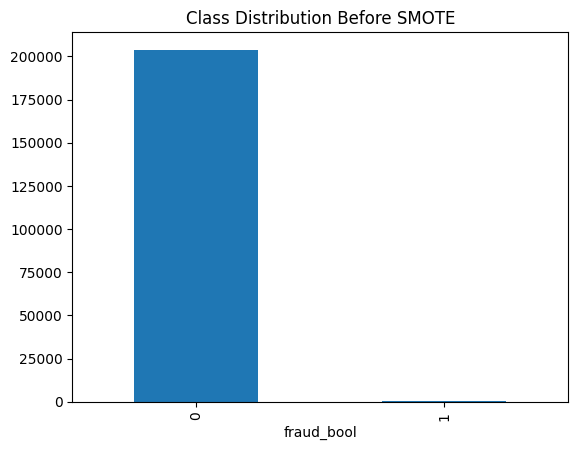

In [12]:
df['fraud_bool'].value_counts().plot(kind = 'bar', title='Class Distribution Before SMOTE')

In [13]:
df_encoded = pd.get_dummies(df, columns = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os'], dtype=int)

<Axes: title={'center': 'Class Distribution After SMOTE'}, xlabel='fraud_bool'>

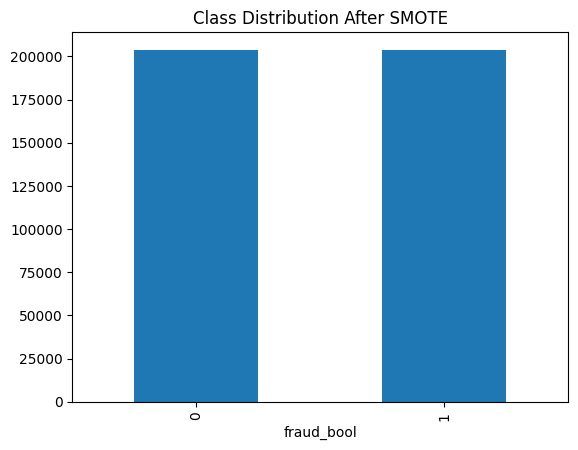

In [14]:
x = df_encoded.drop('fraud_bool', axis = 1)
y = df_encoded['fraud_bool']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)
df_resampled = pd.concat([pd.DataFrame(x_resampled, columns=x.columns),
                          pd.DataFrame(y_resampled, columns=['fraud_bool'])], axis=1)

df_resampled['fraud_bool'].value_counts().plot(kind='bar', title='Class Distribution After SMOTE')

In [15]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407782 entries, 0 to 407781
Data columns (total 53 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   income                            407782 non-null  float64
 1   name_email_similarity             407782 non-null  float64
 2   prev_address_months_count         407782 non-null  int64  
 3   current_address_months_count      407782 non-null  int64  
 4   customer_age                      407782 non-null  int64  
 5   days_since_request                407782 non-null  float64
 6   intended_balcon_amount            407782 non-null  float64
 7   zip_count_4w                      407782 non-null  int64  
 8   velocity_6h                       407782 non-null  float64
 9   velocity_24h                      407782 non-null  float64
 10  velocity_4w                       407782 non-null  float64
 11  bank_branch_count_8w              407782 non-null  i